In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим файлы, необходимые для расчетов. Для того, чтобы загрузить файл X_data, воспользуемся параметром chunksize в pandas.read_csv. Перед тем, как собрать данные в один датафрейм, отсортируем их так, чтобы остались данные за каждый час - для этого воспользуемся функцией chunkprep.

In [5]:
y = pd.read_csv("Y_train.csv", engine = 'python', sep = ';', header = None, names = ['TimeOut','Y'],dtype = {'Date': str, 'Y': np.int32})

In [6]:
y_submit = pd.read_csv("Y_submit.csv", engine = 'python', sep = ';', header = None, names = ['Time','Y'],dtype = {'Date': str, 'Y': np.int32})

In [7]:
df_chunk = pd.read_csv("X_data.csv",sep = ';', chunksize=1000000)

In [8]:
def chunkprep (chunk):
    for a in chunk:
        chunk = chunk[chunk['Unnamed: 0'].str.endswith(':05:00')]
    return chunk

In [9]:
chunk_list = []  

for chunk in df_chunk:
    chunk_filter = chunkprep(chunk)
    chunk_list.append(chunk_filter)
    
df_concat = pd.concat(chunk_list)

In [11]:
X = df_concat.rename(index=str, columns={"Unnamed: 0": "TimeIn"})
X = X.reset_index(drop = True) 

In [12]:
X.head(5)

,TimeIn,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-01 00:05:00,213,211,211,342,350,346,479,473,482,360,349,354,243,241,242,163.81,9.22
1,2015-01-01 01:05:00,209,212,212,297,295,347,525,473,491,326,357,345,242,240,238,165.65,7.82
2,2015-01-01 02:05:00,215,190,211,285,268,361,525,483,490,366,349,342,239,235,239,161.84,6.03
3,2015-01-01 03:05:00,244,213,213,306,234,334,480,486,482,345,345,346,235,236,237,166.26,8.36
4,2015-01-01 04:05:00,233,231,242,359,174,348,431,469,482,333,361,355,240,240,238,164.85,7.02


Для того, чтобы обучить модель на ответах Y_train и сгенерировать предсказания за период, указанный в файле Y_submit, разделим исходный датафрейм X на два датафрейма X_data, X_submit в соотвествии с данными о времени в файлах Y_train, Y_submit. При этом будем учитывать, что данные о сырье и влажности поступают в обжиговую машину на входе, при этом сырье проходит через обжиговую машину за час, а данные о пробах берутся на выходе из обжиговой машины - будем использовать для обучения и генерации предсказаний данные за один час до нужной даты и времени.

In [13]:
X[X.TimeIn == '2018-05-03 22:05:00']

,TimeIn,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
29254,2018-05-03 22:05:00,255,255,260,356,352,354,438,468,441,347,357,344,254,265,248,153.89,8.9


In [14]:
X[X.TimeIn == '2015-01-03 23:05:00']

,TimeIn,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
71,2015-01-03 23:05:00,266,339,263,335,326,341,495,497,535,316,346,336,234,238,239,154.87,4.73


In [15]:
X_data = X[71:29255]
X_data = X_data.reset_index(drop=True)
X_data

,TimeIn,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-03 23:05:00,266,339,263,335,326,341,495,497,535,316,346,336,234,238,239,154.87,4.73
1,2015-01-04 00:05:00,277,326,273,322,335,352,505,501,670,326,379,337,231,236,242,153.77,7.90
2,2015-01-04 01:05:00,277,253,272,320,333,355,500,501,687,337,396,335,234,242,230,158.27,6.96
3,2015-01-04 02:05:00,262,218,260,326,336,330,505,499,443,347,399,332,243,251,240,153.36,7.29
4,2015-01-04 03:05:00,243,238,252,327,329,308,520,498,540,342,387,334,257,258,246,153.21,7.11
5,2015-01-04 04:05:00,236,238,245,323,320,318,522,501,524,343,371,344,264,263,265,195.71,7.97
6,2015-01-04 05:05:00,220,219,217,315,313,318,505,510,507,346,358,347,268,267,266,192.30,7.71
7,2015-01-04 06:05:00,215,207,210,310,321,306,510,498,478,336,349,342,270,269,271,194.18,8.63
8,2015-01-04 07:05:00,200,211,207,310,321,320,501,504,523,355,343,342,266,268,273,192.61,7.78
9,2015-01-04 08:05:00,183,211,210,311,309,305,502,503,541,361,342,347,260,260,268,196.06,7.17


In [16]:
X_submit = X[29255:35063]
X_submit.tail(5)

,TimeIn,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
35058,2018-12-31 18:05:00,266,265,262,356,355,202,452,472,444,348,358,360,281,272,281,181.59,6.95
35059,2018-12-31 19:05:00,265,270,263,365,365,334,362,449,416,340,347,338,277,281,272,184.92,11.00
35060,2018-12-31 20:05:00,263,260,257,378,364,380,458,449,451,333,325,332,277,282,274,188.16,6.38
35061,2018-12-31 21:05:00,268,276,255,370,367,362,481,449,486,327,322,324,277,280,278,184.10,8.37
35062,2018-12-31 22:05:00,320,285,257,352,347,350,481,449,495,325,327,326,277,277,280,158.31,6.13


In [17]:
data = pd.concat([y,X_data], axis = 1)
data = data[['TimeIn',
             'TimeOut',
             'Y',
             'T_data_1_1',
             'T_data_1_2',
             'T_data_1_3',
             'T_data_2_1',
             'T_data_2_2',
             'T_data_2_3',
             'T_data_3_1',
             'T_data_3_2',
             'T_data_3_3',
             'T_data_4_1',
             'T_data_4_2',
             'T_data_4_3',
             'T_data_5_1',
             'T_data_5_2',
             'T_data_5_3',
             'H_data',
             'AH_data']]
data

,TimeIn,TimeOut,Y,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-03 23:05:00,2015-01-04 00:05:00,392,266,339,263,335,326,341,495,497,535,316,346,336,234,238,239,154.87,4.73
1,2015-01-04 00:05:00,2015-01-04 01:05:00,384,277,326,273,322,335,352,505,501,670,326,379,337,231,236,242,153.77,7.90
2,2015-01-04 01:05:00,2015-01-04 02:05:00,393,277,253,272,320,333,355,500,501,687,337,396,335,234,242,230,158.27,6.96
3,2015-01-04 02:05:00,2015-01-04 03:05:00,399,262,218,260,326,336,330,505,499,443,347,399,332,243,251,240,153.36,7.29
4,2015-01-04 03:05:00,2015-01-04 04:05:00,400,243,238,252,327,329,308,520,498,540,342,387,334,257,258,246,153.21,7.11
5,2015-01-04 04:05:00,2015-01-04 05:05:00,417,236,238,245,323,320,318,522,501,524,343,371,344,264,263,265,195.71,7.97
6,2015-01-04 05:05:00,2015-01-04 06:05:00,408,220,219,217,315,313,318,505,510,507,346,358,347,268,267,266,192.30,7.71
7,2015-01-04 06:05:00,2015-01-04 07:05:00,404,215,207,210,310,321,306,510,498,478,336,349,342,270,269,271,194.18,8.63
8,2015-01-04 07:05:00,2015-01-04 08:05:00,405,200,211,207,310,321,320,501,504,523,355,343,342,266,268,273,192.61,7.78
9,2015-01-04 08:05:00,2015-01-04 09:05:00,405,183,211,210,311,309,305,502,503,541,361,342,347,260,260,268,196.06,7.17


In [20]:
y.head()

,TimeOut,Y
0,2015-01-04 00:05:00,392
1,2015-01-04 01:05:00,384
2,2015-01-04 02:05:00,393
3,2015-01-04 03:05:00,399
4,2015-01-04 04:05:00,400


Построим корреляционную матрицу. Наиболее сильную зависимость с целевой переменной имеют датчики в 3 камере, также существует сильная зависимость между датчиками температур внутри камер.

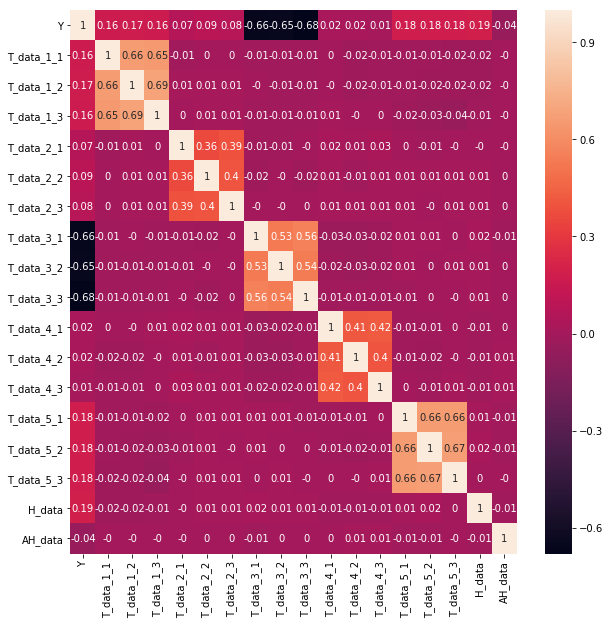

In [18]:
plt.figure(figsize = (10,10))
corr_matrix= data.corr().round(2)
sns.heatmap(data = corr_matrix, annot = True)

Для начала построим модель линейной регрессии

In [20]:
#Regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [22]:
X_t = X_data[[
             'T_data_1_1',
             'T_data_1_2',
             'T_data_1_3',
             'T_data_2_1',
             'T_data_2_2',
             'T_data_2_3',
             'T_data_3_1',
             'T_data_3_2',
             'T_data_3_3',
             'T_data_4_1',
             'T_data_4_2',
             'T_data_4_3',
             'T_data_5_1',
             'T_data_5_2',
             'T_data_5_3',
             'H_data',
             'AH_data']]
y_t = y["Y"]
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.33, random_state=42)

In [23]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
y_train_predict = lm.predict(X_train)
mae = mean_absolute_error(y_train,y_train_predict)
r2 = r2_score(y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lm.predict(X_test)
mae = mean_absolute_error(y_test, y_test_predict)
r2 = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('R2 score is {}'.format(r2))
print("\n")

print("Cross_val_score")
print("--------------------------------------")
print("Train cross_val_score R2",cross_val_score(lm, X_train, y_train, cv=5, scoring='r2'),cross_val_score(lm, X_train, y_train, cv=5, scoring='r2').mean())
print("Test cross_val_score R2", cross_val_score(lm, X_test, y_test, cv=5, scoring='r2'),cross_val_score(lm, X_test, y_test, cv=5, scoring='r2').mean())
print("Train cross_val_score MAE",abs(cross_val_score(lm, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')),abs(cross_val_score(lm, X_train, y_train, cv=5,  scoring='neg_mean_absolute_error')).mean())
print("Test cross_val_score MAE", abs(cross_val_score(lm, X_test, y_test, cv=5, scoring='neg_mean_absolute_error')),abs(cross_val_score(lm, X_test, y_test, cv=5,  scoring='neg_mean_absolute_error')).mean())

The model performance for training set
--------------------------------------
MAE is 14.91987457842206
R2 score is 0.7663240788814888


The model performance for testing set
--------------------------------------
MAE is 14.994697559154218
R2 score is 0.7603349016767781


Cross_val_score
--------------------------------------
Train cross_val_score R2 [0.75182559 0.7866723  0.73969    0.76222362 0.77378853] 0.7628400077056805
Test cross_val_score R2 [0.76265539 0.76840211 0.70359473 0.77821833 0.7643219 ] 0.7554384927066632
Train cross_val_score MAE [15.20068938 14.89059255 14.61668254 14.92038275 15.1367993 ] 14.953029304702136
Test cross_val_score MAE [14.56193552 15.31312653 15.22565874 15.10771701 14.83952099] 15.009591757543694


Постараемся улучшить качество прогноза. Воспользуемся моделью градиентного бустинга на деревьях. Для определения лучших параметров будем использовать поиск по сетке параметров GridSearchCV.

In [30]:
#gbm
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

gbm = XGBRegressor()
reg_cv = GridSearchCV(gbm, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2, 1.5]
                            ,'max_depth': [6,8], 'n_estimators': [500,1000]}, verbose=1)
reg_cv.fit(X_train,y_train)
reg_cv.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 21.8min finished


{'colsample_bytree': 1.0,
 'max_depth': 6,
 'min_child_weight': 1.2,
 'n_estimators': 500}

In [25]:
print(reg_cv.best_score_)
print(reg_cv.best_params_)

0.927697639508897
{'colsample_bytree': 1.0, 'max_depth': 6, 'min_child_weight': 1.2, 'n_estimators': 500}


In [32]:
gbm = XGBRegressor(**reg_cv.best_params_)
gbm.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1.2, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [33]:
gbm.score(X_train,y_train)

0.9763306756505765

In [28]:
y_train_predict = gbm.predict(X_train)
mae = mean_absolute_error(y_train,y_train_predict)
r2 = r2_score(y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = gbm.predict(X_test)
mae = mean_absolute_error(y_test, y_test_predict)
r2 = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('R2 score is {}'.format(r2))
print("\n")

print("Cross_val_score")
print("--------------------------------------")
print("Train cross_val_score R2",cross_val_score(gbm, X_train, y_train, cv=5, scoring='r2'),cross_val_score(gbm, X_train, y_train, cv=5, scoring='r2').mean())
print("Test cross_val_score R2", cross_val_score(gbm, X_test, y_test, cv=5, scoring='r2'),cross_val_score(gbm, X_test, y_test, cv=5, scoring='r2').mean())
print("Train cross_val_score MAE",abs(cross_val_score(gbm, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')),abs(cross_val_score(gbm, X_train, y_train, cv=5,  scoring='neg_mean_absolute_error')).mean())
print("Test cross_val_score MAE", abs(cross_val_score(gbm, X_test, y_test, cv=5, scoring='neg_mean_absolute_error')),abs(cross_val_score(gbm, X_test, y_test, cv=5,  scoring='neg_mean_absolute_error')).mean())

The model performance for training set
--------------------------------------
MAE is 5.316714928911415
R2 score is 0.9763306756505765


The model performance for testing set
--------------------------------------
MAE is 8.95522154114004
R2 score is 0.9337673001449658


Cross_val_score
--------------------------------------
Train cross_val_score R2 [0.92793469 0.92909442 0.93301163 0.92743527 0.92891665] 0.9292785316046276
Test cross_val_score R2 [0.92569286 0.92840441 0.92333987 0.92925607 0.92531143] 0.9264009272574203
Train cross_val_score MAE [9.25080837 9.09264406 8.86665329 9.25700522 9.29486035] 9.15239425894198
Test cross_val_score MAE [9.51897132 9.5072217  9.46738967 9.28600583 9.42648508] 9.441214720816737


Качество прогоноза заметно улучшилось. C помощью полученной модели сгенерируем предсказания за период, указанный в файле Y_submit.

In [34]:
X_submit = X_submit[['T_data_1_1',
             'T_data_1_2',
             'T_data_1_3',
             'T_data_2_1',
             'T_data_2_2',
             'T_data_2_3',
             'T_data_3_1',
             'T_data_3_2',
             'T_data_3_3',
             'T_data_4_1',
             'T_data_4_2',
             'T_data_4_3',
             'T_data_5_1',
             'T_data_5_2',
             'T_data_5_3',
             'H_data',
             'AH_data']]
preds = gbm.predict(X_submit)
preds = preds.astype(int)
y_submit['Y'] = preds
y_submit.to_csv('Y_submit_Kandybko O.E.csv',sep = ";", index = False)